Importing relevant packages

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


# Imports for the MLP Regressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam



# Time Series Analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

2023-06-28 19:16:52.327317: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-28 19:16:52.475560: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-28 19:16:52.487410: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-28 19:16:55.066353: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Loading the dataset and printing first 3 rows:

In [2]:
df = pd.read_csv('../data/PETR4.SA.csv', parse_dates=['Date'], index_col='Date')
df.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,5.875,5.875,5.875,5.875,1.563740,3.538944e+10
2000-01-04,5.550,5.550,5.550,5.550,1.477235,2.886144e+10
2000-01-05,5.494,5.494,5.494,5.494,1.462330,4.303360e+10


Let's have a look at some statistics:

In [3]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5898.000000,5898.000000,5898.000000,5898.000000,5898.000000,5.898000e+03
mean,19.141195,19.417342,18.843884,19.125684,6.989928,5.493729e+08
std,9.528718,9.663342,9.377653,9.519757,4.737233,3.893731e+09
min,4.200000,4.270000,4.120000,4.200000,1.164487,0.000000e+00
25%,10.400938,10.550000,10.228125,10.401250,3.157507,2.150572e+07
50%,19.549999,19.900000,19.270000,19.549999,6.395513,3.476770e+07
75%,26.180000,26.600000,25.790001,26.200001,9.218781,5.601185e+07
max,52.580002,53.680000,51.950001,52.509998,31.850000,7.356416e+10


Evolution of the closing stock price from 01/2000 to 06/2023 (grouped by 5 days):

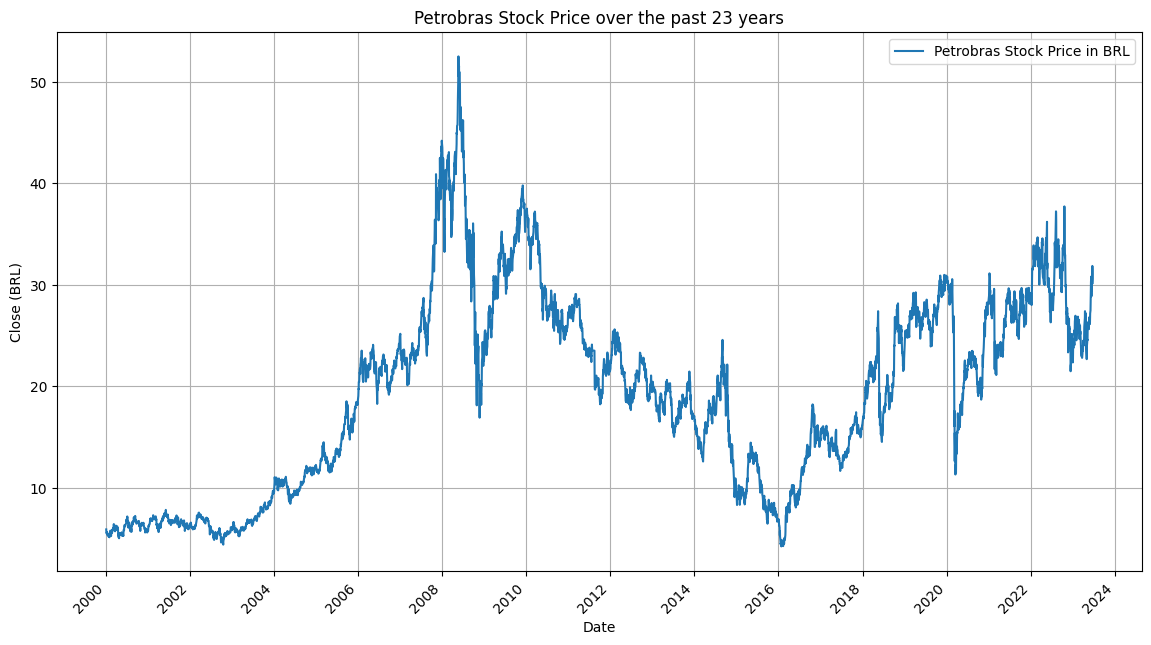

In [4]:
import matplotlib.dates as mdates

plt.figure(figsize=(14,7))
sns.lineplot(x=df.index, y=df['Close'], label='Petrobras Stock Price in BRL')

plt.ylabel('Close (BRL)')
plt.title('Petrobras Stock Price over the past 23 years')
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend()
plt.grid(True)

Same plot, but grouped by 10 days to reduce noise and improve readability:

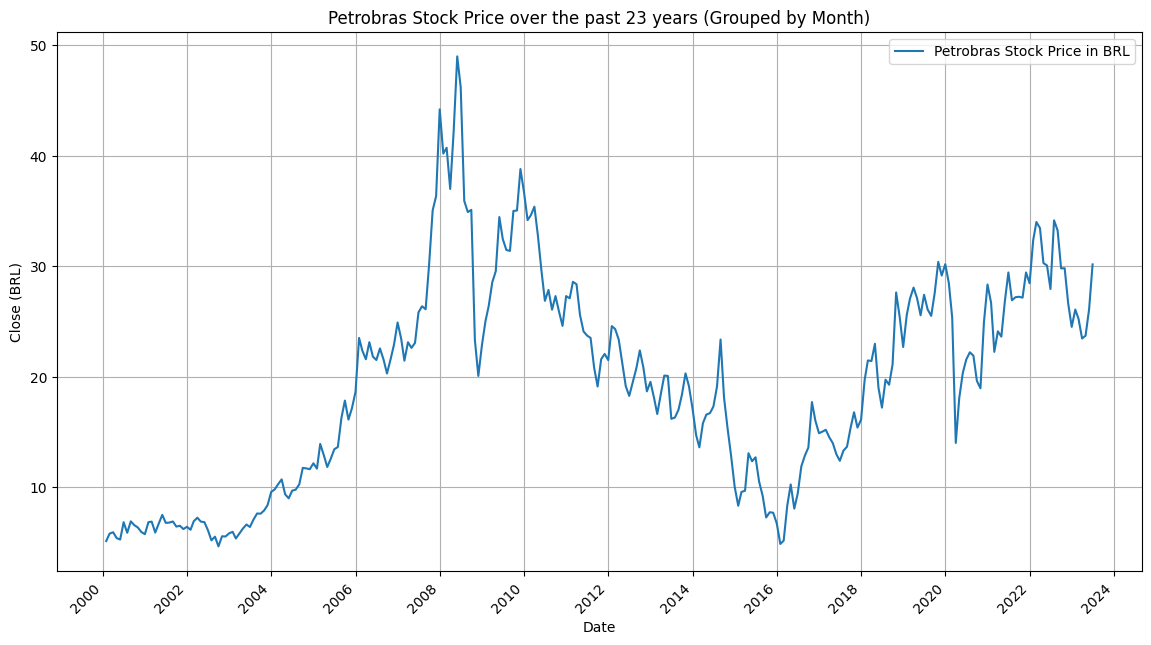

In [5]:
import matplotlib.dates as mdates

plt.figure(figsize=(14,7))
sns.lineplot(x=df.resample('1M').last().index, y=df.resample('1M').last()['Close'], label='Petrobras Stock Price in BRL')

plt.ylabel('Close (BRL)')
plt.title('Petrobras Stock Price over the past 23 years (Grouped by Month)')
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend()
plt.grid(True)

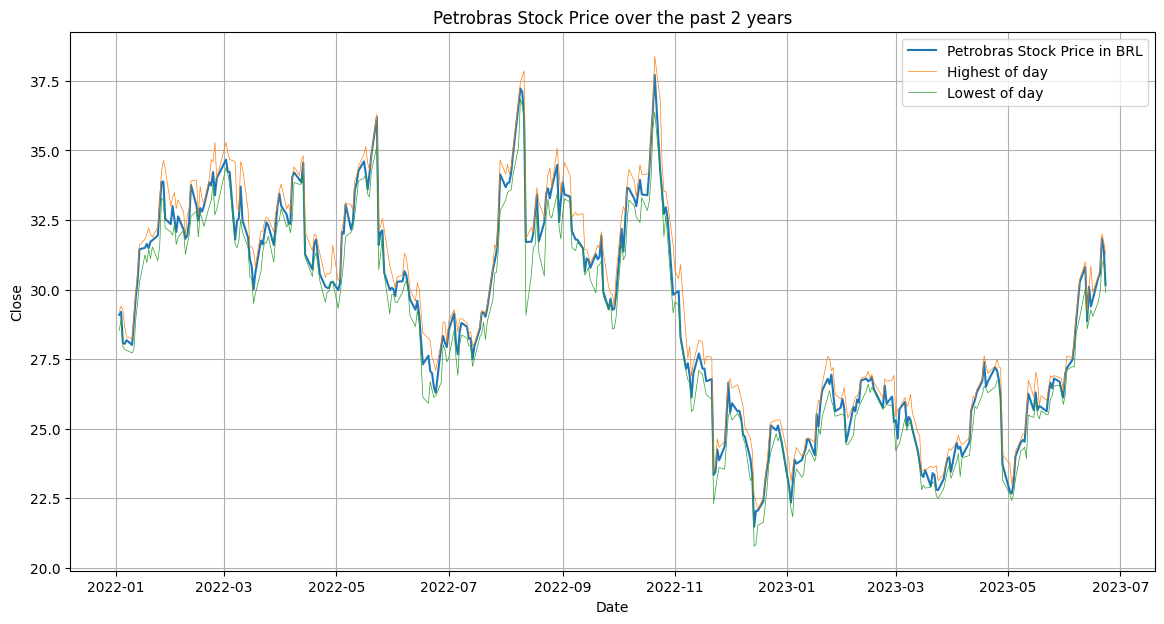

In [6]:
plt.figure(figsize=(14,7))

data_2023 = df.loc['2022':'2023']
sns.lineplot(x=data_2023.index, y=data_2023['Close'], label='Petrobras Stock Price in BRL')
sns.lineplot(x=data_2023.index, y=data_2023['High'], label='Highest of day', linewidth=0.5)
sns.lineplot(x=data_2023.index, y=data_2023['Low'], label='Lowest of day', linewidth=0.5)
plt.title('Petrobras Stock Price over the past 2 years')
plt.grid(True);

Correlation plot:

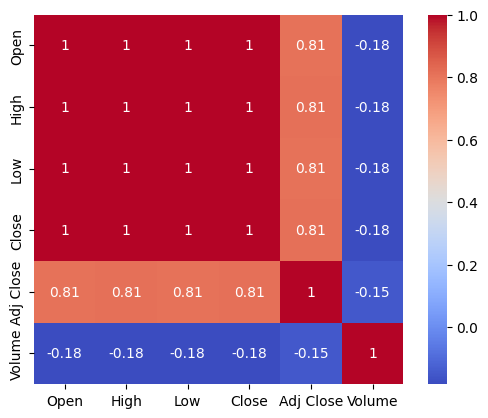

In [7]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', square=True);

Checking the distribution of the closing price:

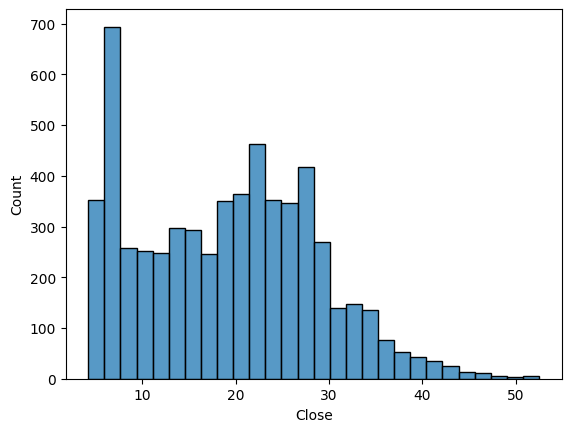

In [8]:
sns.histplot(df['Close']);

In [9]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

# Predicting the stock price with ML

Splitting Train & Test data

In [11]:
df_close = df[['Close']]

In [13]:
n_train = int(len(df_close) * 0.8)
n_test = len(df_close) - n_train

# We divide them, except the 
train, test = df_close.iloc[:n_train], df.iloc[n_train:len(df_close)]

print(f'Train: {len(train)}\nTest length: {len(test)}')

Train: 4718
Test length: 1180


Convert to Time Series Data

In [14]:
def get_timeseries(x, n_steps=1):
    x_ts, y_ts = [], []
    for ii in range(len(x) - n_steps):
        v = x.iloc[ii:(ii + n_steps)].values
        x_ts.append(v)
        w = x.iloc[ii + n_steps].values
        y_ts.append(w)
    return np.array(x_ts), np.array(y_ts)


n_steps = 6
X_train, y_train = get_timeseries(train, n_steps)
X_test, y_test = get_timeseries(test,n_steps)

In [15]:
print(X_train.shape, y_train.shape)

(4712, 6, 1) (4712, 1)


## Define the model

In [67]:
lr = 0.0001 
optimizer = Adam(learning_rate=lr)

model = Sequential()
model.add(Dense(50, activation='relu', input_dim=n_steps))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=optimizer)
pipeline = make_pipeline(MinMaxScaler(), model)

history = model.fit(X_train, y_train, epochs=300, batch_size=64)

Epoch 1/300
74/74 [==============================] - 2s 5ms/step - loss: 34.9898
Epoch 2/300
74/74 [==============================] - 0s 4ms/step - loss: 3.6714
Epoch 3/300
74/74 [==============================] - 0s 4ms/step - loss: 0.5291
Epoch 4/300
74/74 [==============================] - 0s 4ms/step - loss: 0.4338
Epoch 5/300
74/74 [==============================] - 0s 4ms/step - loss: 0.4319
Epoch 6/300
74/74 [==============================] - 0s 4ms/step - loss: 0.4298
Epoch 7/300
74/74 [==============================] - 0s 3ms/step - loss: 0.4253
Epoch 8/300
74/74 [==============================] - 0s 4ms/step - loss: 0.4168
Epoch 9/300
74/74 [==============================] - 0s 4ms/step - loss: 0.4088
Epoch 10/300
74/74 [==============================] - 0s 4ms/step - loss: 0.4047
Epoch 11/300
74/74 [==============================] - 0s 4ms/step - loss: 0.4016
Epoch 12/300
74/74 [==============================] - 0s 4ms/step - loss: 0.3997
Epoch 13/300
74/74 [================

In [64]:
y_pred = model.predict(X_test)

37/37 [==============================] - 0s 5ms/step


array([35056260., 29100370., 27006964., 28117094., 26106522., 26168698.],
      dtype=float32)

In [71]:
accuracy = accuracy_score(y_test[0][0], y_pred[0][0])
print("Accuracy score:", accuracy)


InvalidParameterError: The 'y_true' parameter of accuracy_score must be an array-like or a sparse matrix. Got 20.24 instead.

In [63]:
y_pred = y_pred.reshape(1174,6)

(1174, 6)

ValueError: Classification metrics can't handle a mix of continuous-multioutput and multiclass-multioutput targets

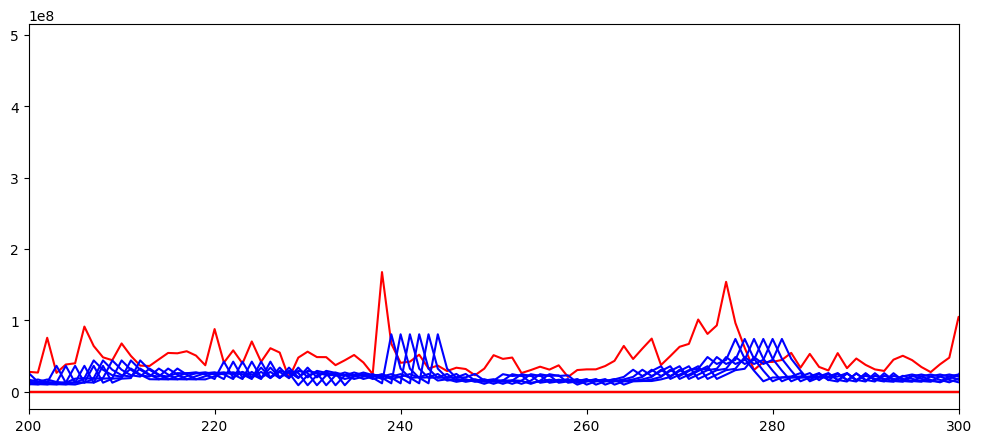

In [58]:
fig = plt.figure(figsize=(12,5))
fig.set_dpi(100)


plt.plot(y_train, label="Actual Data", color='g')
plt.plot(y_test, label="Actual Data", color='r')
plt.plot(y_pred, label="Actual Data", color='b')
plt.xlim(200, 300);

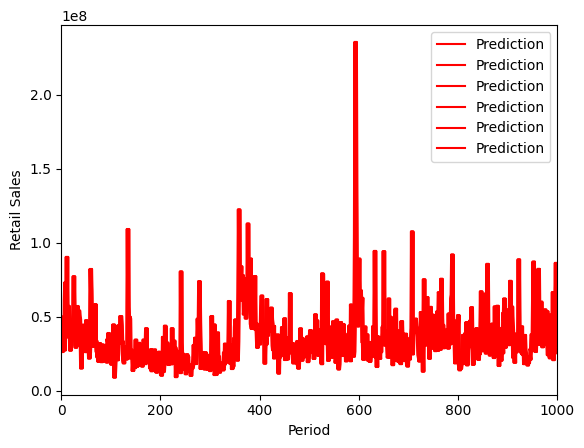

In [55]:

plt.plot(y_pred, 'r', label="Prediction")
plt.ylabel('Retail Sales')
plt.xlabel('Period')
plt.legend()

plt.show();

In [ ]:
df['Vol.'] = df['Vol.'].str.replace('M', '').astype('float64')*10**6
df.info()
df.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2023-06-23 to 2023-01-02
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   120 non-null    float64
 1   Vol.    119 non-null    float64
dtypes: float64(2)
memory usage: 2.8 KB


/tmp/ipykernel_8154/1359166843.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Vol.'] = df['Vol.'].str.replace('M', '').astype('float64')*10**6
/tmp/ipykernel_8154/1359166843.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 119 entries, 2023-06-23 to 2023-01-02
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   119 non-null    float64
 1   Vol.    119 non-null    float64
dtypes: float64(2)
memory usage: 2.8 KB


<Axes: xlabel='Date', ylabel='Price'>

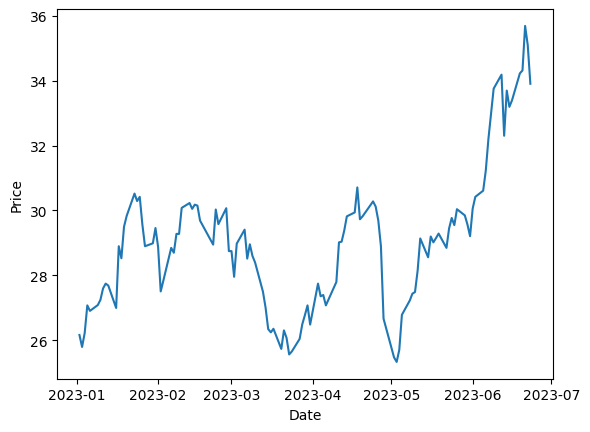

In [ ]:
sns.lineplot(x='Date', y='Price', data=df)

In [ ]:
df.head()

,Price,Vol.
Date,,
2023-06-23,33.90,11740000.0
2023-06-22,35.09,13630000.0
2023-06-21,35.68,16980000.0
2023-06-20,34.31,20060000.0
2023-06-19,34.22,5670000.0


continue with a time series while await response

In [ ]:
# Generate sample data for training
X = np.random.rand(100, 5)  # Input features (e.g., historical demand, price, etc.)
y = np.random.rand(100)     # Target variable (e.g., demand)

# Scale the input features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create and train the MLPRegressor model
model = MLPRegressor(hidden_layer_sizes=(10, 10), activation='relu', solver='adam', random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
score = model.score(X_test, y_test)
print(f"R^2 Score: {score}")

# Make predictions on new data
new_data = np.random.rand(5)  # New input features
new_data_scaled = scaler.transform(new_data.reshape(1, -1))
prediction = model.predict(new_data_scaled)
print(f"Predicted demand: {prediction}")

R^2 Score: -0.15759178213164926
Predicted demand: [0.39117564]


In [ ]:
y.shape

(100,)

In [ ]:
# Generate sample data for training
X = df[['Price']].values # Input features (e.g., historical demand, price, etc.)
y = df['Price']     # Target variable (e.g., demand)

# Scale the input features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create and train the MLPRegressor model
model = MLPRegressor(hidden_layer_sizes=(50, 50), activation='relu', solver='adam', random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
score = model.score(X_test, y_test)
print(f"R^2 Score: {score}")

# Make predictions on new data
new_data = pd.DataFrame()  # New input features
new_data_scaled = scaler.transform(new_data.reshape(1, -1))
prediction = model.predict(new_data_scaled)
print(f"Predicted demand: {prediction}")

R^2 Score: -6.482635456344343


/home/fmaron/.pyenv/versions/petropredict/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


ValueError: at least one array or dtype is required

array([33.9 , 35.09, 35.68, 34.31, 34.22, 33.39, 33.19, 33.69, 32.3 ,
       34.18, 33.75, 32.2 , 31.23, 30.61, 30.42, 30.06, 29.21, 29.57,
       29.85, 30.04, 29.55, 29.77, 29.45, 28.85, 29.29, 29.15, 29.02,
       29.2 , 28.56, 29.14, 28.15, 27.49, 27.44, 27.23, 26.79, 25.71,
       25.34, 25.48, 26.67, 28.9 , 29.69, 30.12, 30.28, 29.82, 29.73,
       30.71, 29.94, 29.82, 29.38, 29.04, 29.02, 27.8 , 27.08, 27.4 ,
       27.36, 27.75, 26.49, 27.08, 26.78, 26.5 , 26.05, 25.66, 25.57,
       26.08, 26.31, 25.74, 26.36, 26.25, 26.35, 27.01, 27.5 , 28.4 ,
       28.6 , 28.96, 28.52, 29.41, 28.98, 27.96, 28.75, 28.75, 30.07,
       29.58, 30.03, 28.95, 29.69, 30.15, 30.18, 30.05, 30.23, 30.08,
       29.28, 29.28, 28.7 , 28.85, 27.84, 27.51, 28.88, 29.46, 28.99,
       28.9 , 29.57, 30.42, 30.29, 30.52, 29.83, 29.5 , 28.53, 28.9 ,
       27.  , 27.69, 27.75, 27.6 , 27.25, 27.09, 26.91, 27.08, 26.23,
       25.8 , 26.17])